In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re

In [2]:
train = pd.read_csv('./training_set.csv')
train = train.drop(columns=['Unnamed: 0'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      3910 non-null   float64
 1   X2      3910 non-null   float64
 2   X3      3910 non-null   float64
 3   X4      3910 non-null   float64
 4   X5      3910 non-null   float64
 5   X6      3910 non-null   float64
 6   X7      3910 non-null   float64
 7   X8      3910 non-null   float64
 8   X9      3910 non-null   float64
 9   X10     3910 non-null   float64
 10  X11     3910 non-null   float64
 11  X12     3910 non-null   float64
 12  X13     3910 non-null   float64
 13  X14     3910 non-null   float64
 14  X15     3910 non-null   float64
 15  X16     3910 non-null   float64
 16  X17     3910 non-null   float64
 17  X18     3910 non-null   float64
 18  X19     3910 non-null   float64
 19  X20     3910 non-null   float64
 20  X21     3910 non-null   float64
 21  X22     3910 non-null   float64
 22  

# Feature Selection / Dimensionality Reduction

I have tried several methods for feature selection and the summary of the methods are outlined below:

1. Univariate Feature Selection
    - Multicollinearity Analysis Using Heat map and VIF
    - ANOVA correlation coefficient
    - Mututal Information 
2. Recursive Feature Elimination (Top down approach)
    - Logistic Regression
    - LinearSVC
3. Sequential Feature Selection (Bottom up approach)
    - KNeighborsClassifier
    - Tree based Models
4. Principal Componenet Analysis (PCA)

## 1.A Multicolinearity Analysis Using Correlation Matrix and VIF

Text(0.5, 1.0, 'Correlation Heatmap')

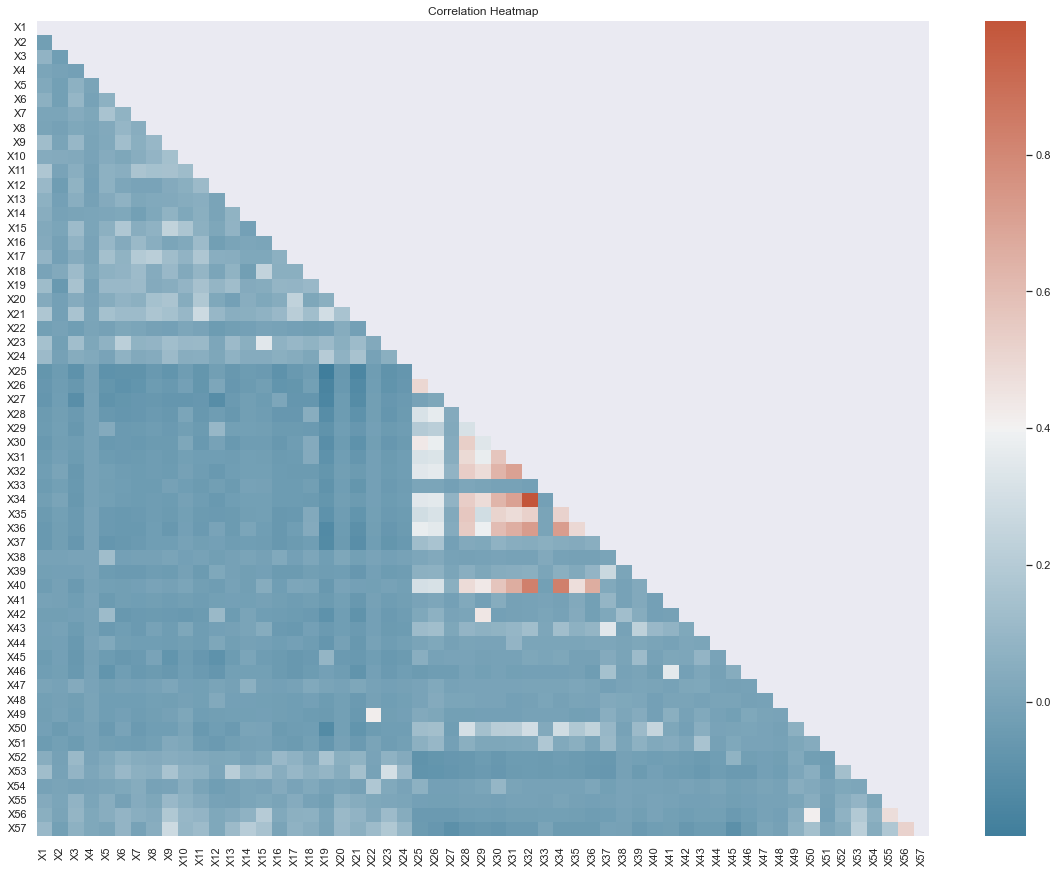

In [40]:
# corr = train.drop(columns=['Y']).corr()
f, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap)
plt.title('Correlation Heatmap')

In [35]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
train = train.drop(columns=to_drop)
train.shape

(3910, 57)

From the above plot we see that Features X34 and X32 are highly correlated, and also X40 is correlated with X32 and X34, For regression analysis it is important to drop highly correlated columns and hence I have decided to drop X34 for further analysis, I also confirm the same observation by calculating VIF where we regress each column with all the others and confirm that X34 and X32 are having high VIF values and hence can be dropped. It is also evident from the pair plots below.

Text(0.5, 1.0, 'VIF plot: Columns vs VIF')

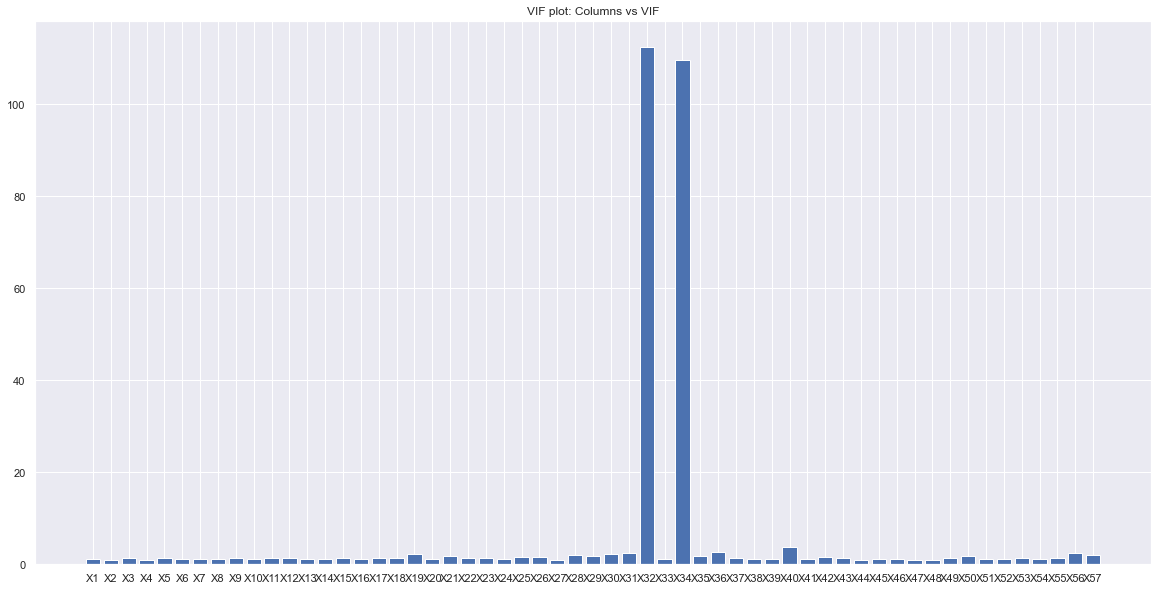

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X = train.drop(columns=['Y'])
# vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
cols = X.columns.values
f, ax = plt.subplots(figsize=(20, 10))
ax.bar(cols,vif)
plt.title('VIF plot: Columns vs VIF')

Text(0.5, 1.08, "'Pair plot of X32, X34 and X40'")

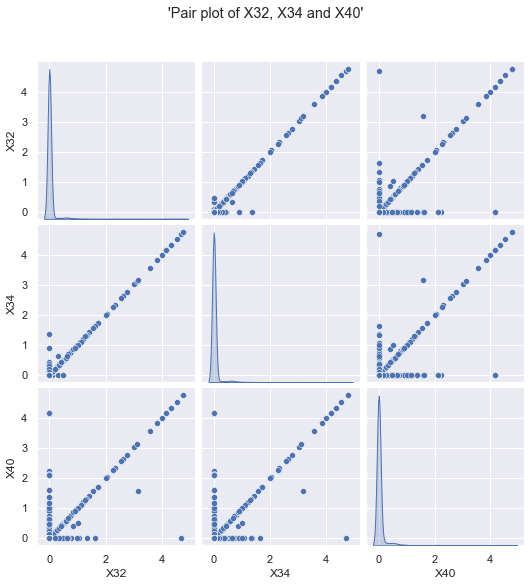

In [42]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
cData_attr = train[['X32','X34','X40']]
g = sns.pairplot(cData_attr, diag_kind='kde')
g.fig.suptitle("'Pair plot of X32, X34 and X40'", y=1.08)

## 1.B, 1.C ANNOVA and Mutual Information

Text(0.5, 1.0, 'Plot representing the level of significance of 30 best features using ANOVA')

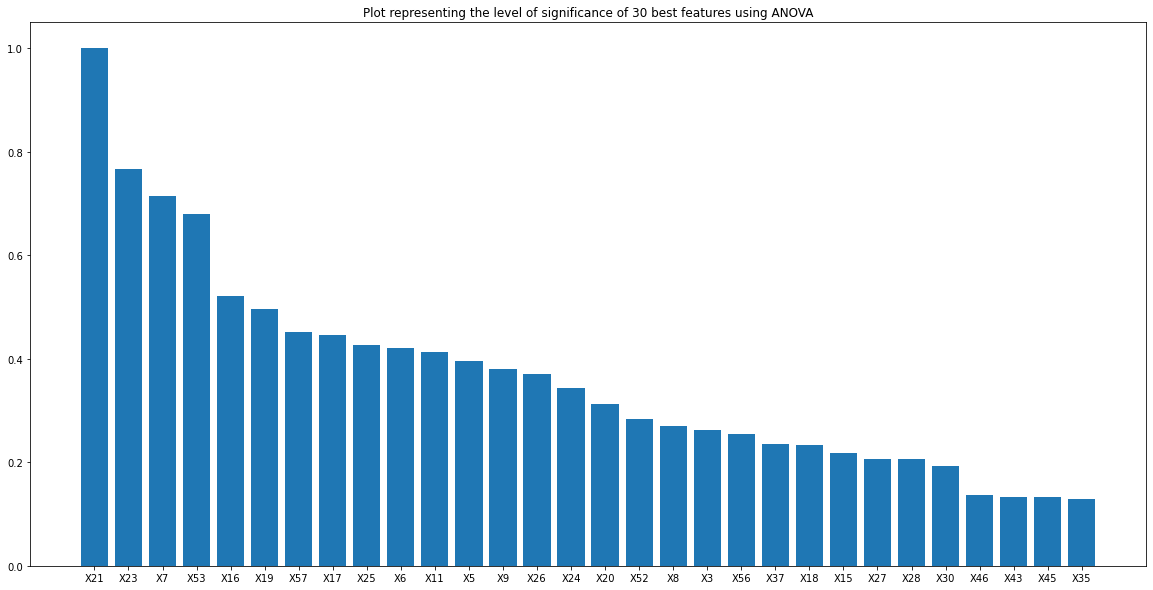

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

X = train.drop(columns=['Y'])
y = train['Y']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4535, stratify=True, shuffle=True)

# Let us select 30 features
select = SelectKBest(f_classif, k=30)
select.fit(X, y)
scores = -np.log10(select.pvalues_)
scores /= scores.max()

feature_importance = list(zip(X_train.columns.values, scores))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]

f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Plot representing the level of significance of 30 best features using ANOVA')

In [ ]:
#30 best features according to Mutual information
select = SelectKBest(mutual_info_classif, k=30)
select.fit(X, y)
scores = -np.log10(select.pvalues_)
scores /= scores.max()

feature_importance = list(zip(X_train.columns.values, scores))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]

f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Plot representing the level of significance of 30 best features using ANOVA')

## 2.A Recursive Feature Elimination using weights of Logistic Regression Model

Text(0.5, 1.0, 'Selected Features according to RFE and LinearSVC')

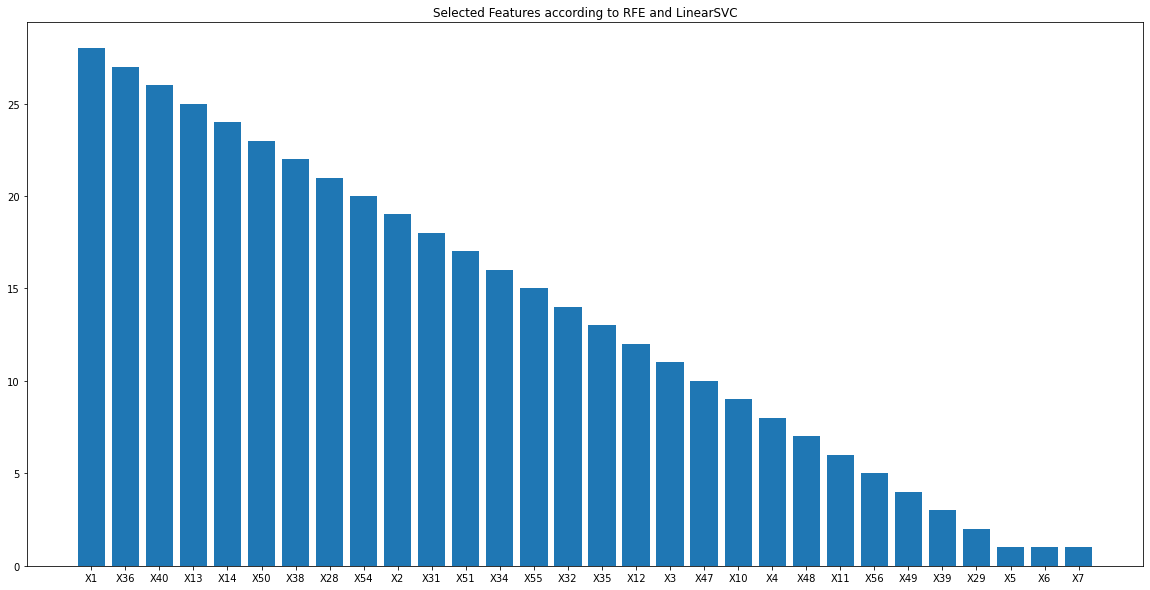

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE

scaled_X = MinMaxScaler().fit_transform(X)
estimator = LogisticRegression()
selectorr = RFE(estimator,n_features_to_select=30, step=1)
selectorr = selectorr.fit(scaled_X, y)
rank = selectorr.ranking_

feature_importance = list(zip(X_train.columns.values, rank))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]
f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Selected Features according to RFE and Logistic Regression')

Text(0.5, 1.0, 'Selected Features according to RFE and LinearSVC')

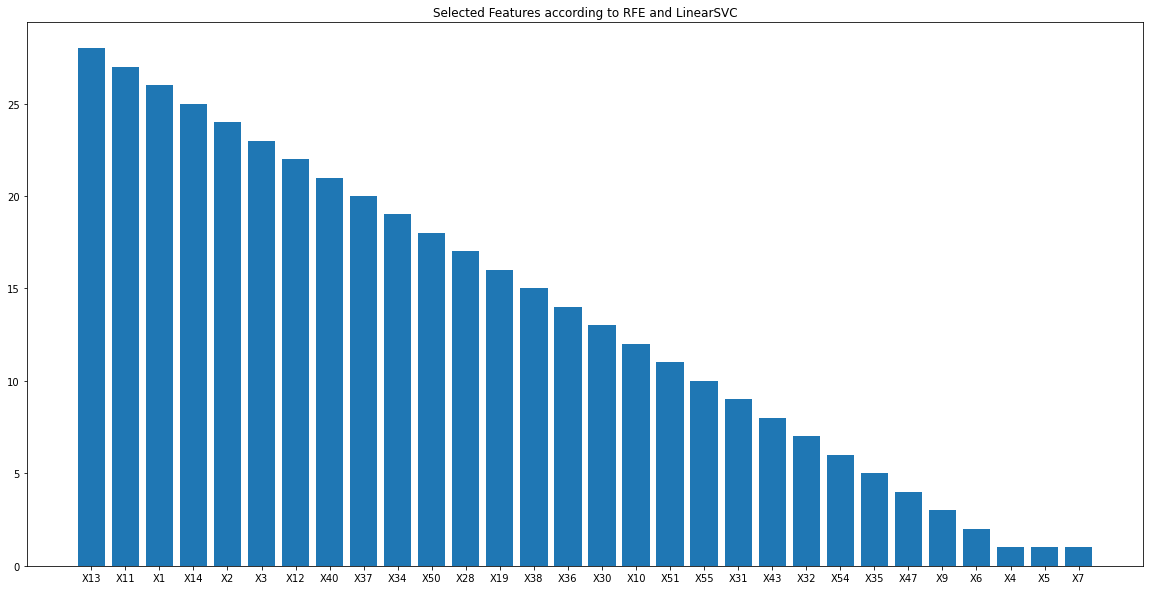

In [36]:
estimator = LinearSVC()
selectorr = RFE(estimator,n_features_to_select=30, step=1)
selectorr = selectorr.fit(scaled_X, y)
rank = selectorr.ranking_

feature_importance = list(zip(X_train.columns.values, rank))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]
f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Selected Features according to RFE and LinearSVC')

## 3. Sequential Feature Selection using KNeighborsClassifier and DecisionTreeClassifier

In [54]:
%%time
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(weights='distance')
sfs = SequentialFeatureSelector(estimator, n_features_to_select=30, n_jobs=-1, cv=2, scoring='accuracy')
sfs.fit(X, y)
fi_Neighbors = X.columns.values[sfs.support_]
fi_Neighbors

CPU times: total: 16.4 s
Wall time: 2min 31s


In [55]:
%%time
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(estimator, n_features_to_select=30, n_jobs=-1, cv=2, scoring='accuracy')
sfs.fit(X, y)
fi_tree_fwd = X.columns.values[sfs.support_]
fi_tree_fwd

CPU times: total: 15.2 s
Wall time: 28.7 s


In [52]:
%%time
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(estimator, direction='backward',n_features_to_select=30, n_jobs=-1, cv=2, scoring='accuracy')
sfs.fit(X, y)
fi_tree_bwd = X.columns.values[sfs.support_]

array(['X2', 'X3', 'X5', 'X6', 'X7', 'X13', 'X17', 'X18', 'X20', 'X21',
       'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X35',
       'X40', 'X41', 'X43', 'X46', 'X48', 'X49', 'X52', 'X53', 'X54',
       'X55', 'X56'], dtype=object)

# PCA

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
pca.fit(X)
pca_x = pca.transform(X)
sum(pca.explained_variance_ratio_)

0.9999949348116871

# Modelling

I have created a Voting Classifier Which takes in estimators fitted from all the feature selection method that has been described above.

In [120]:
from sklearn.pipeline import Pipeline

# I have dropped X34 column using the First feature selection method

def create_classifiers(n_features, final_classifier):
#     final_classifier = final_classifier()
    clf1 = Pipeline([
      ('feature_selection', SelectKBest(f_classif, k=n_features)),
      ('scale', StandardScaler()),
      ('classification', final_classifier)
    ])

    clf2 = Pipeline([
      ('feature_selection', SelectKBest(mutual_info_classif, k=n_features)),
      ('scale', StandardScaler()),
      ('classification', final_classifier)
    ])

    clf3 = Pipeline([
        ('scale', MinMaxScaler()),
        ('feature_selection', RFE(LogisticRegression(),n_features_to_select=n_features, step=1)),
        ('classification', final_classifier)
    ])

    clf4 = Pipeline([
        ('scale', MinMaxScaler()),
        ('feature_selection', RFE(LinearSVC(),n_features_to_select=n_features, step=1)),
        ('classification', final_classifier)
    ])

    clf5 = Pipeline([
        ('feature_selection', SequentialFeatureSelector(KNeighborsClassifier(weights='distance'), n_features_to_select=n_features, n_jobs=-1, cv=2, scoring='accuracy')),
        ('scale', StandardScaler()),
        ('classification', final_classifier)
    ])

    clf6 = Pipeline([
        ('feature_selection', SequentialFeatureSelector(DecisionTreeClassifier(), n_features_to_select=n_features, n_jobs=-1, cv=2, scoring='accuracy')),
        ('scale', StandardScaler()),
        ('classification', final_classifier)
    ])

    clf7 = Pipeline([
        ('feature_selection', SequentialFeatureSelector(DecisionTreeClassifier(), direction='backward',n_features_to_select=n_features, n_jobs=-1, cv=2, scoring='accuracy')),
        ('scale', StandardScaler()),
        ('classification', final_classifier)
    ])

    clf8 = Pipeline([
        ('feature_selection', PCA(n_components=n_features)),
        ('scale', StandardScaler()),
        ('classification', final_classifier)
    ])
    
    return [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]

In [121]:
%%time
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

clfs = create_classifiers(30, SVC(probability=True))
clf = VotingClassifier(estimators=[('clf'+str(i), clfs[i]) for i in range(len(clfs))],voting='soft')

clf.fit(X_train,y_train)
test_pred = clf.predict(X_test)
train_pred = clf.predict(X_train)
accuracy_score(test_pred, y_test), precision_score(y_pred=test_pred, y_true=y_test), recall_score(y_pred=test_pred, y_true=y_test)

CPU times: total: 1min 4s
Wall time: 4min 9s


(0.9360613810741688, 0.9381107491856677, 0.9028213166144201)

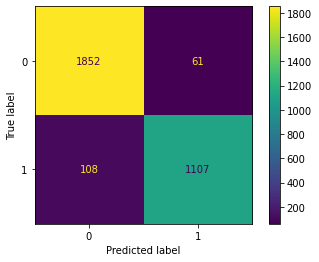

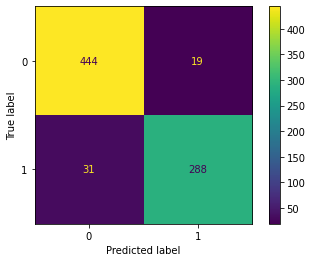

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, train_pred)
ConfusionMatrixDisplay.from_predictions(y_test, test_pred)

In [123]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.9742310270350786

# Model Evaluation

In [112]:
%%time
from tqdm import tqdm
from datetime import datetime

num_features = [10, 20, 30, 40, 50, 57]
roc_auc_tree = []
roc_auc_LinearSVC = []

for i in tqdm(num_features):
    s = datetime.now()
    LogRegclf = create_classifiers(i, LogisticRegression)
    LRclf = VotingClassifier(estimators=[('clf'+str(i), clfs[i]) for i in range(len(LogRegclf))],voting='soft')
    
    LinearSVCclf = create_classifiers(i, LinearSVC)
    LSVCclf = VotingClassifier(estimators=[('clf'+str(i), clfs[i]) for i in range(len(LinearSVCclf))],voting='soft')
    
    LRclf.fit(X_train,y_train)
    LSVCclf.fit(X_train,y_train)
    
    LRclf_pred = LRclf.predict(X_test)
    LSVCclf_pred = LSVCclf.predict(X_test)
    
    roc_auc_LogReg.append(roc_auc_score(LRclf_pred, LRclf.predict_proba(X_test)[:, 1]))
    roc_auc_LinearSVC.append(roc_auc_score(LSVCclf_pred, LSVCclf.predict_proba(X_test)[:, 1]))
    
    print('Done in {} min for {} features'.format((datetime.now()-s).total_seconds()/60, i))

 17%|█████████████▊                                                                     | 1/6 [10:41<53:27, 641.47s/it]

Done in 10.691195066666667 min for 10 features


 33%|███████████████████████████▋                                                       | 2/6 [21:01<41:56, 629.15s/it]

Done in 10.34182395 min for 20 features


 50%|█████████████████████████████████████████▌                                         | 3/6 [31:52<31:56, 638.69s/it]

Done in 10.833992533333333 min for 30 features


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [41:53<20:48, 624.02s/it]

Done in 10.025331566666667 min for 40 features


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [49:29<09:23, 563.37s/it]

Done in 7.597212600000001 min for 50 features


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [57:03<00:00, 570.57s/it]

Done in 7.567560916666666 min for 57 features
CPU times: total: 12min 25s
Wall time: 57min 3s
